### Makemore

Another Karpathy tutorial: https://github.com/karpathy/makemore 

Makemore is a character-level language model. It treats every word as a sequence of individual characters. So makemore just predicts the next character. It takes in one text file as input, where each line is assumed to be one training thing, and generates more things like it. 

It will be implemented through different techniques and neural net archictectures, increasing in complexity. So we will move from the character-level to the word-level. This notebook will be a Bigram model.

#### Bigram

With a bigram, we work with two characters at a time, i.e. we are given one character and we try to predict the next one in the sequence. It ignores all other information.

In [5]:
# Read in the names - splitlines ensures it is a list of words rather than one long string
names = open('names.txt', 'r').read().splitlines()

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
print("Number of names: ", len(names)) # 32,033
print("Shortest name: ", min(len(w) for w in names)) # 2
print("Longest name: ", max(len(w) for w in names)) # 15

Number of names:  32033
Shortest name:  2
Longest name:  15


Taking 'Isabella' as an example - what is there to be aware of? That 'I' is likely to be the first letter of a name, that 's' is likely to come after 'I', that 'a' is likely to come after 's', etc. After 'Isabella', the word is likely to end. 32,000 examples like this - so there's a lot of structure for the language model to learn.

In [6]:
# We want 2 characters at a time. The for loops + zip function will do that.
# As an example, let's just do the first word
for w in names[:1]:
 for ch1, ch2 in zip(w, w[1:]):
  print(ch1, ch2)

  # The word is emma and returned is 'em', 'mm', 'ma'. 

e m
m m
m a


The above is obviously limited, as we actually have more info than what is contained in the 3 elements above. I.e., we know 'e' is likely to come first in a name, etc. So we will create special characters to stand in as tokens for start and end characters.

In [2]:
# Grab first name
for w in names[:1]:
 # w becomes a list of characters. Add the start & end tokens.
 chs = ['<S>'] + list(w) + ['<E>']
 for ch1, ch2 in zip(chs, chs[1:]):
  print(ch1, ch2)

  # The word is emma and returned is '<S>e' 'em', 'mm', 'ma', 'a<E>'. 

<S> e
e m
m m
m a
a <E>


It now starts with a bigram of the start token and e, ..., finishing with a bigram of a and the end token.

Now we need to learn the statistics of which characters are likely to follow which characters. The simplest way is to do it by counting combinations. We will add a dictionary to maintain the counts of every combination.

In [8]:
b = {}
for w in names:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2) # store in a tuple
        b[bigram] = b.get(bigram, 0) + 1 # in case that bigram is not in the dictionary, by default return a 0 + 1

In [14]:
# Contains statistics for each combo
# By default, sorted is for the first item in a tuple but we want it on the second. Key argument does this.
sorted(b.items(), key = lambda kv: -kv[1])[:5]

# Most common: 'n<E>', 'a<E>', 'an', '<S>a', 'e<E>'.

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

### Using PyTorch tensors

It is more convenient to keep this in a 2D array than a python dictionary. The rows will be the first character, the columns the second character. Each entry will give us the counts. 

In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# By default, pytorch uses float objects so convert to int32.
# It is a (28,28) array for 26 letters + 2 special characters.
N = torch.zeros((28,28), dtype=torch.int32)

In [6]:
# We need to index into the array using integers, so we need a look-up table.
# We can do this by concatenating all the words and putting them in a set for the unique letters
# Convert to a list and make sure it's sorted from a-z.
print("Number of items in set: ", len(set(''.join(names))))

chars = sorted(list(set(''.join(names))))

Number of items in set:  26


In [22]:
# Create integer - letter mapping
stoi = {s:i for i,s in enumerate(chars)}
list(stoi.items())[:5]

[('a', 0), ('b', 1), ('c', 2), ('d', 3), ('e', 4)]

In [23]:
# Also need to set special token mappings
stoi['<S>'] = 26
stoi['<E>'] = 27

In [24]:
# Using the array
for w in names:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [26]:
# Before we can plot, we need to reverse character - integer mapping
itos = {i:s for s,i in stoi.items()}
list(itos.items())[:5]

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e')]

(-0.5, 27.5, 27.5, -0.5)

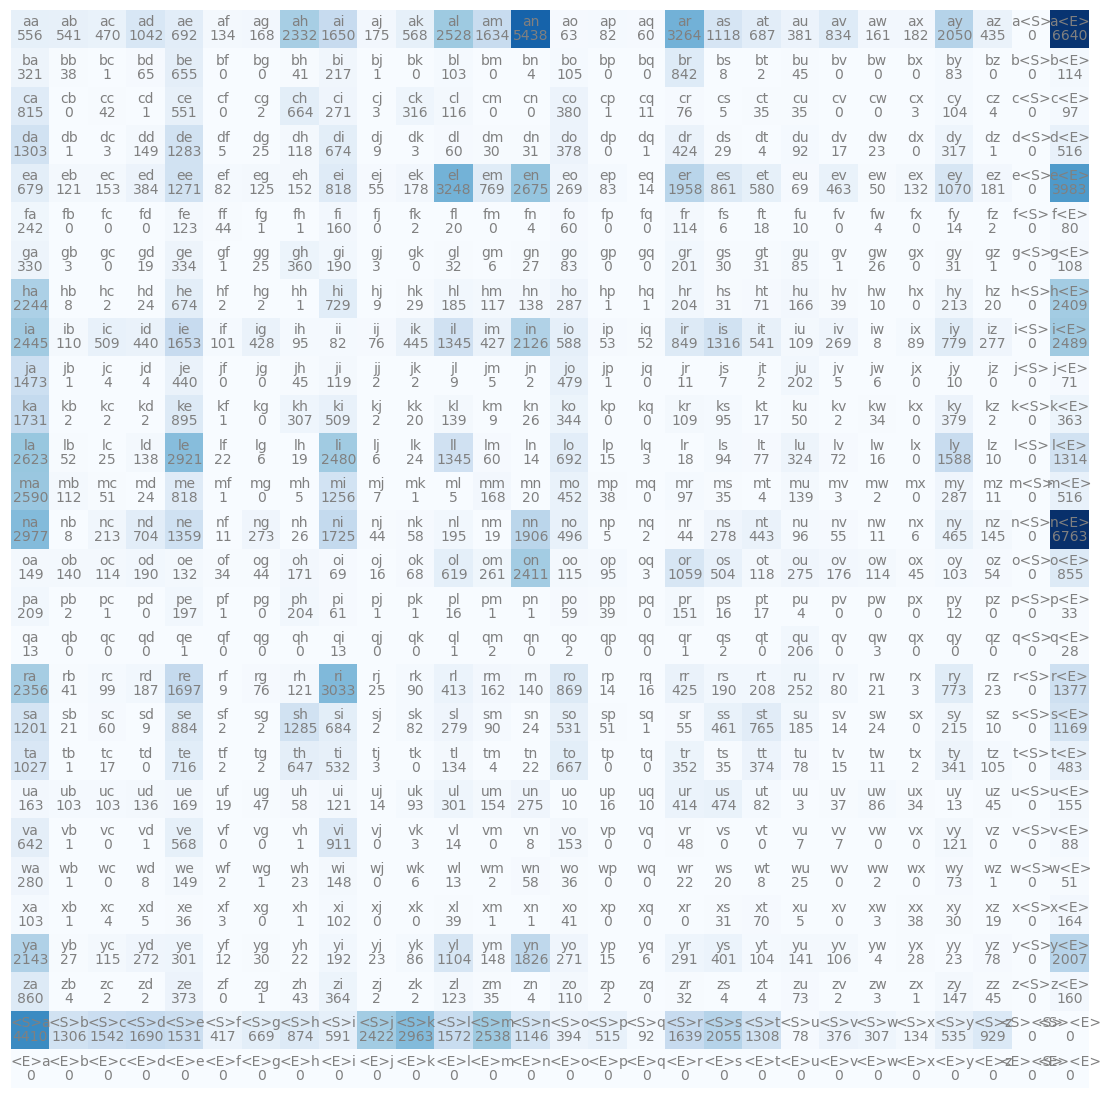

In [28]:
# Rows are first letter, columns are second letter. 
plt.figure(figsize=(14,14))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]

        # Plot bigram text
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")

        # Plot number of times bigram occurs. .item() plus the integer from the tensor.
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis("off")

We can improve on the above. We have an entire row/column where the special characters are all 0s. This wastes space. The convention within the deep learning space is to use the <> brackets to denote special tokens but we will change this for this exercise.

We will have just one special token.

In [7]:
# Change to 27x37
N = torch.zeros((27,27), dtype=torch.int32)

# Reset stoi
stoi = {s:i+1 for i,s in enumerate(chars)}

# . will be the new special character and move to position 0 (aesthetic only)
stoi['.'] = 0

# Again reverse the mapping
itos = {i:s for s,i in stoi.items()}

In [9]:
# Change
for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

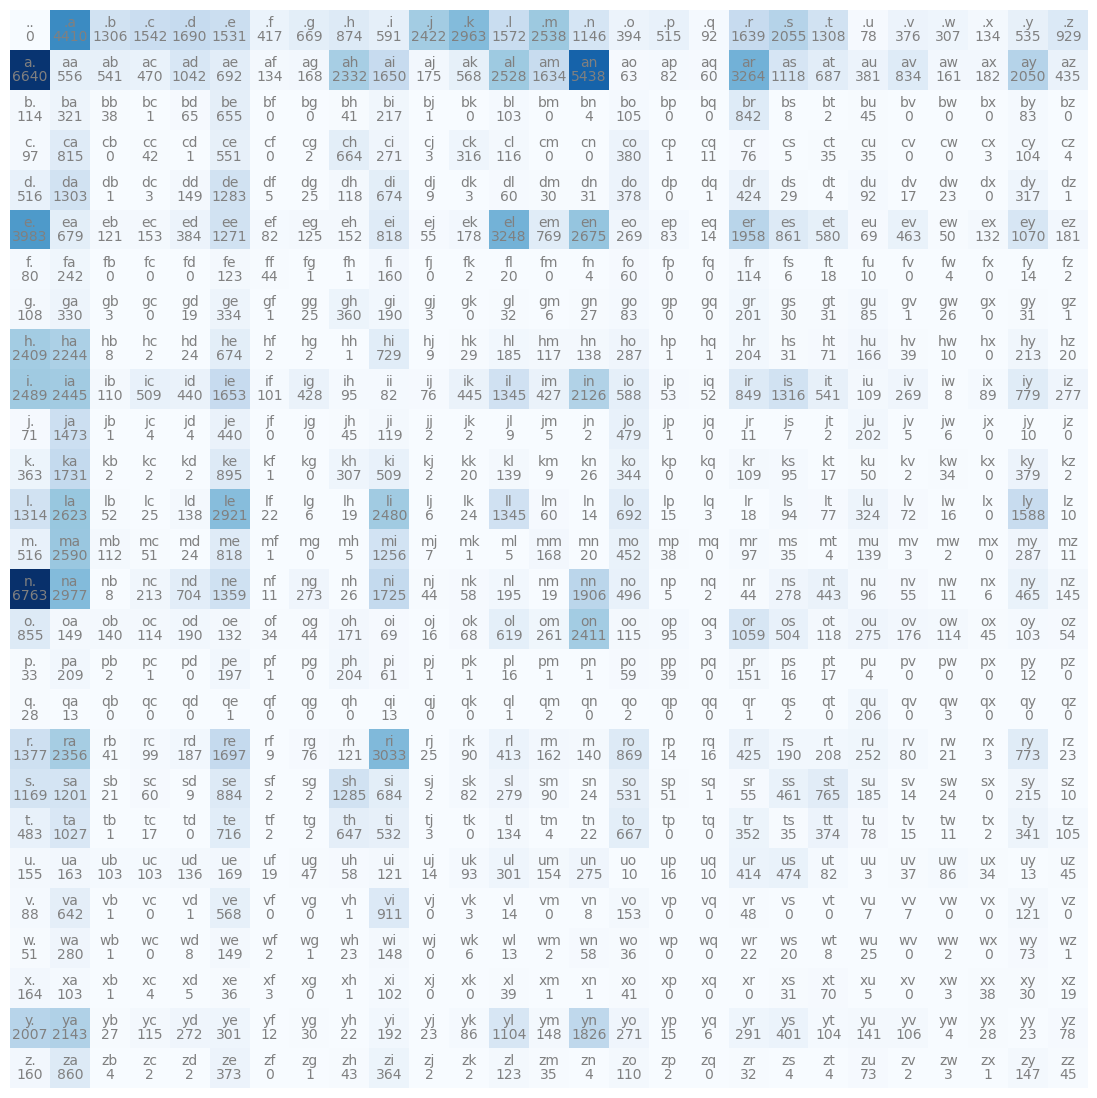

In [10]:
# We now go up to 27
plt.figure(figsize=(14,14))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]

        # Plot bigram text
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")

        # Plot number of times bigram occurs. .item() plus the integer from the tensor.
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis("off")

The above array contains all the information we need to sample from. We will follow the probabilities from the counts contained above. 

Again, the first row is telling us the counts of how often the letter started a word. So dividing each letter by the sum will give us the probability of a word starting with any given letter.

### Sampling

In [12]:
# Gives us the counts for the first row
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [13]:
# Probability vector. Normalise to sum to 1. 
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

To sample, we will use torch.Multinomial. If you give it probabilities, it will give you integers according to those probabilities. 

To make everything deterministic, we will use a generator object. 

In [14]:
# Generator
g = torch.Generator().manual_seed(2147483647)

# Create 3 random numbers, held fixed by generator
p = torch.rand(3, generator=g) 

# Normalise
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [15]:
# Draw samples using torch.multinomial
# Pass probabilities + number of samples you want.
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

The above gives us samples that follow the defined distribution. As can be seen with p, we expect 61% of samples to be 0, 30% to be 1, and 9% to be 2. The more we sample, the more the numbers should have the given distribution.

In [18]:
# Actual thing we're interested in
p = N[0].float()
p = p / p.sum()

g = torch.Generator().manual_seed(2147483647)

# Just 1 example
# This returns a number - so the index of the letter we're interested in
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

This returns number 10. Which corresponds to the letter J. Which has a 9.25% chance of being the first letter out of 26 letters, which seems likely.

To draw the next character, we take the row that starts with J. We will write out the loop instead of taking this letter by letter.

In [22]:
# Create a few examples
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = N[ix].float()
        p = p / p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        # If end of word, break
        if ix == 0:
            break

    print(''.join(out))

junide.
janasah.
p.
cony.
a.


Prints out "Junide" - which could be namelike. Also "janasah", "p", "cony", "a".

The reason the samples are terrible is because a bigram language model is terrible. Some could be namelike but many are just individual letters. This is because a very common letter after "p" or "a" is an end character. 

A way we can check the bigram is doing something is by creating a uniform distribution rather than our probability distribution and check the output.

In [23]:
# Create a few examples
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        # Uniform distirbution
        p = torch.ones(27) / 27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        # If end of word, break
        if ix == 0:
            break

    print(''.join(out))

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.


And we get even more complete nonsense out - very long strings of letters. This is what happens when a model is untrained or when everything is equally likely. 

The trained model is the bigram - which isn't great, but it's better than a uniform distribution.

We can make this computationally more efficient. Currently, we keep referring to the count table, converting to float, and normalising repeatedly. Let's store all the probabilities in a matrix instead. This is also good practice for matrix/tensor manipulation and broadcasting.

In [37]:
# Grab float copy of N
P = N.float()

# We cannot do P / P.sum() because this is the sum of the whole matrix.
# We just want the sums of the rows in the matrix.

print(P.shape) # A 27x27 matrix
print(P.sum(0, keepdim=True).shape) # A 1x27 vector
print(P.sum(0).shape) # A 1D vector of size 27
print(P.sum(1, keepdim=True).shape) # A 27x1 vector
print(P.sum(1).shape) # A 1D vector of size 27

torch.Size([27, 27])
torch.Size([1, 27])
torch.Size([27])
torch.Size([27, 1])
torch.Size([27])


In [39]:
# Do it this way so it does inplace operations rather than creating a new object.
P /= P.sum(1, keepdim=True)
P[0].sum() # Equals 1, which is correct.

tensor(1.)

Is it possible to take a 27x27 array and divide by a 27x1 array? Yes. Two tensors are "broadcastable" if:
* Each tensor has at least one dimension
* The dimension sizes are equal, one of them is 1, or one of them does not exist.

In our case, they're not equal, but one of them is 1, so it's fine. In the other column, they are equal (both 27). So this operation is allowed. What will happen is that the 1D vector is copied 27 times in order to make the division possible (both equal 27x27). Then an element-wise division.

Trying the code above using the matrix still works fine. 

Karpathy recommends reading broadcasting semantics. It is something to properly understand and practice. 

### Loss function

We want to summarise the quality of the model into a single number - a training "loss". 

In [41]:
# Look at probabilities for each bigram.
for w in names[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960


Bear in mind, if everything was equally likely, each would have a probability of 1/27 = ~ 3.7%. So anything above this number means we've learned something through the bigram statistics.

A good model would assign high probabilities to the next token, especially on the training set. 

How can we summarise the above probabilities into a single number than evaluates the quality of the model. We do this with the "likelihood". This is the product of all the probabilities. Their product should be as high as possible. Because multiplying all those probabilities would result in a very small number, we instead work with the log-likelihood for convenience. This works mathematically because log(a*b*c) = log(a) + log(b) + log(c). In maths language: "maximising the likelihood is the same as maximising the log likelihood, because log is a monotonic function." I.e. it only scales the loss function, nothing else. 

The log is a monotonic transformation. A probability of 1 returns a log probability of 0. Lower probabilities become much more negative. 

In [42]:
for w in names[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299


In [50]:
log_likelihood = 0.0
n = 0

for w in names[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}') # -30.08

nll = -log_likelihood
print(f'{nll=}') # 30.08

# Normalised negative log-likelihood
print(f'{nll/n}') # 2.51

log_likelihood=tensor(-30.0801)
nll=tensor(30.0801)
2.506679058074951


The log-likehood can go as high as 0 in cases where all probabilities are 1. Anything less and the log-likelihood goes more negative. We want a loss function that we can minimise. So we work instead with the negative log-likelihood. The lowest this can get is 0, when a model is perfect. 

A last convenience is that people prefer to work with averages than sums, so we take the average. In the case above, the loss is 2.51 - that is the quality of the bigram model. 

The job of training the model is to find the parameters that minimise the average negative log likelihood.

In [52]:
# Over the entire training set:
log_likelihood = 0.0
n = 0

for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}') # -559,891.75

nll = -log_likelihood
print(f'{nll=}') # 559,891.75

# Normalised negative log-likelihood
print(f'{nll/n}') # 2.45

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


In [54]:
# We can even evaluate the likelihood for any given word:
log_likelihood = 0.0
n = 0

for w in ["nicolas"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}') # -21.04

nll = -log_likelihood
print(f'{nll=}') # 21.04

# Normalised negative log-likelihood
print(f'{nll/n}') # 2.63


# Slightly worse than average, so an unlikely name.
# This appears to be because N is a relatively unlikely letter to start with, as is the combo "ic" and "as".

.n: 0.0358 -3.3305
ni: 0.0941 -2.3631
ic: 0.0288 -3.5489
co: 0.1076 -2.2294
ol: 0.0780 -2.5508
la: 0.1879 -1.6717
as: 0.0330 -3.4114
s.: 0.1442 -1.9365
log_likelihood=tensor(-21.0424)
nll=tensor(21.0424)
2.630305290222168


If I were to test out "Andrejq", it would return a probability of 0, because q never follows j. We can solve this by adding fake counts - adding 1 to each count. Without 0s, there will be no infinities in likelihood.